In [1]:
import pickle

import numpy as np
import seaborn as sns
import pandas as pd
from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

sns.set_style("white")

In [2]:
class Message:
    '''Class to keep sender, timestamp, public (To/Cc) and hidden (Bcc) recipients of a message
    
    Must map the Message class fields in parseMaildir.py for deserialization purposes
    '''
    def __init__(self, From, mtime, To, Cc, Bcc):
        self.From = From
        self.mtime = mtime
        self.To = To
        self.Cc = Cc
        self.Bcc = Bcc

In [3]:
parsed_logs_folder = 'Enron/parsing/'
social_graph = pickle.load(open(parsed_logs_folder + "social.pkl", "rb"))
emails_per_num_of_recipients = pickle.load(open(parsed_logs_folder + "recipients.pkl", "rb"))
log = pickle.load(open(parsed_logs_folder + "replay_log.pkl", "rb"))
email_status = pickle.load(open(parsed_logs_folder + "email_status.pkl", "rb"))

enc_status = {0: "plaintext", 1: "stale", 2: "encrypted"}

In [4]:
userset = set()

for user in social_graph.keys():
        userset.add(user)

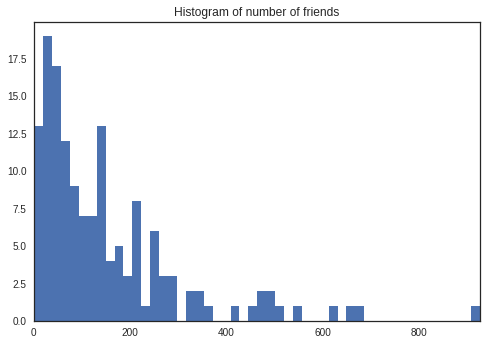

In [5]:
data = [info["num_of_friends"] for info in social_graph.values()]
plt.hist(data, bins=50)
plt.xlim(0, max(data))
plt.title("Histogram of number of friends")
plt.show()

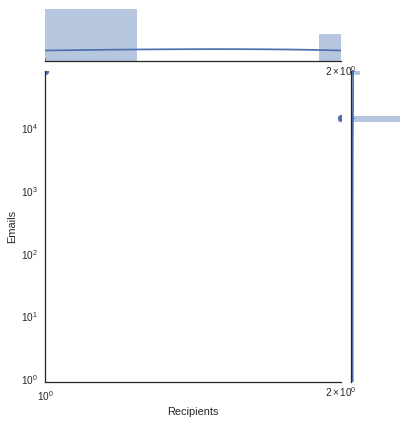

In [6]:
x, y = zip(*sorted(emails_per_num_of_recipients.items(), key=lambda t: t[0]))
data = pd.DataFrame({'Recipients': x, 'Emails': y})

logbins=np.logspace(0,np.log(10000), 100)

g = sns.JointGrid('Recipients', 'Emails', data,xlim=[1, max(data['Recipients'])],ylim=[0.9, max(data['Emails'])])
g.plot_joint(plt.scatter)
g.plot_marginals(sns.distplot, rug=True, bins=logbins)

ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g.ax_marg_x.set_xscale('log')
g.ax_marg_y.set_yscale('log')
plt.show()

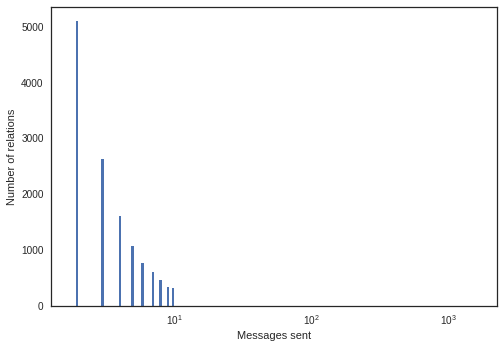

In [7]:
comm_links = {}

for email in log:
    recipients = email.To | email.Cc | email.Bcc - {email.From}
    
    for recipient in recipients:
        if recipient not in userset and email.From not in userset:
            continue
        sorted_actors = sorted([email.From, recipient])
        if (sorted_actors[0], sorted_actors[1]) not in comm_links:
            comm_links[(sorted_actors[0], sorted_actors[1])] = 1
        else: 
            comm_links[(sorted_actors[0], sorted_actors[1])] += 1

data = [num_of_msgs for num_of_msgs in comm_links.values()]
plt.gca().set_xscale("log")
plt.hist(data, bins=np.logspace(0.1, 1.0, 50))
plt.xlim(0, max(data))
plt.xlabel("Messages sent")
plt.ylabel("Number of relations")

plt.show()

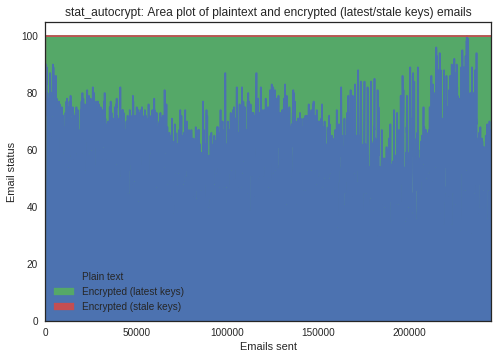

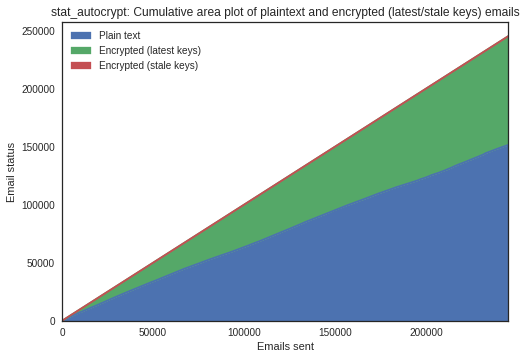

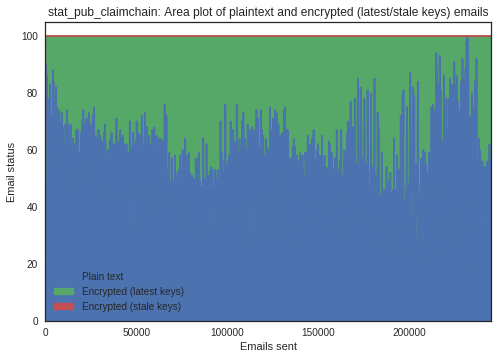

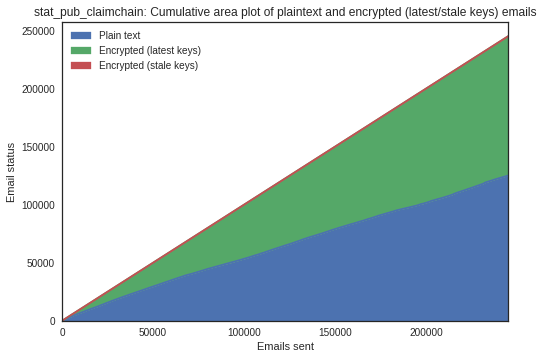

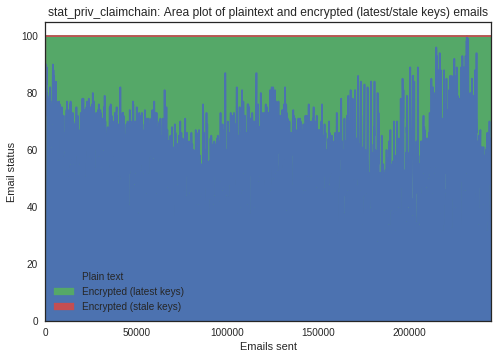

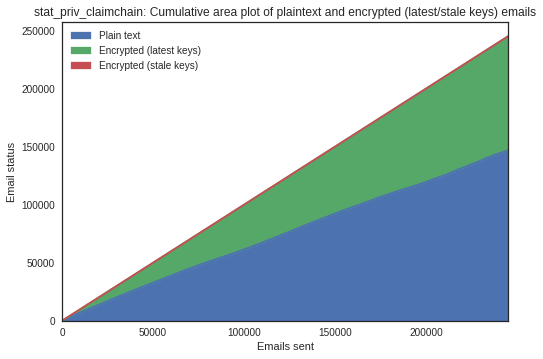

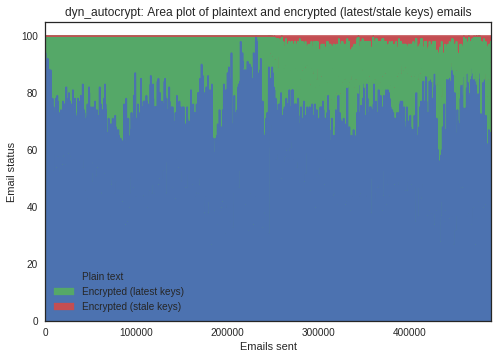

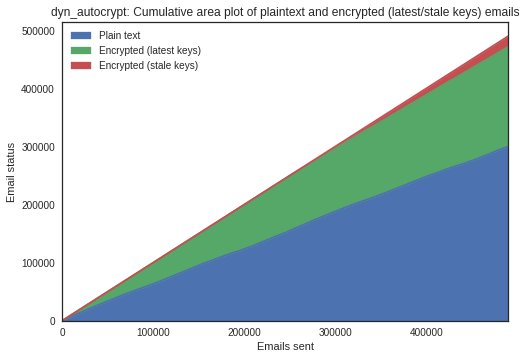

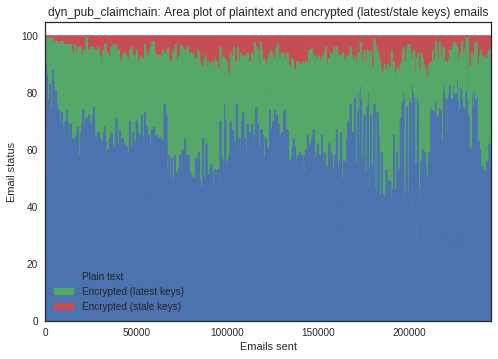

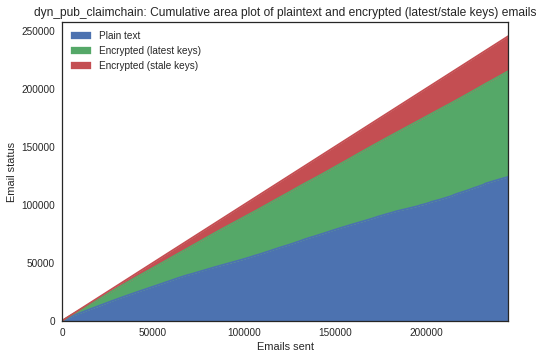

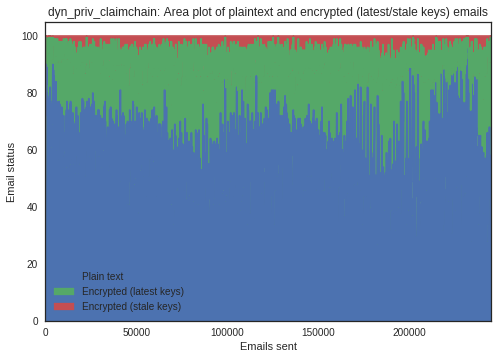

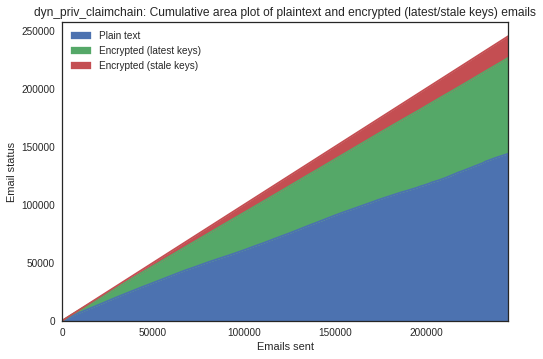

In [8]:
df_dict = {}
df_cumulative_dict = {}

for scenario in email_status.keys():
    df_dict[scenario] = pd.DataFrame(columns=('Plain text', 'Encrypted (latest keys)', 'Encrypted (stale keys)'))
    df_cumulative_dict[scenario] = pd.DataFrame(columns=('Plain text', 'Encrypted (latest keys)', 'Encrypted (stale keys)'))
    enc_status_counter = {}
    enc_status_cumulative_counter = {}
    for status in enc_status.values():
        enc_status_counter[status] = 0
        enc_status_cumulative_counter[status] = 0
    
    for index, email in enumerate(email_status[scenario]):
        enc_status_counter[enc_status[email]] += 1
        enc_status_cumulative_counter[enc_status[email]] += 1
            
        if index % 100 == 0:
            df_dict[scenario].loc[index] = [enc_status_counter["plaintext"], enc_status_counter["encrypted"], enc_status_counter["stale"]]
            df_cumulative_dict[scenario].loc[index] = [enc_status_cumulative_counter["plaintext"], enc_status_cumulative_counter["encrypted"], enc_status_cumulative_counter["stale"]]
            for status in enc_status.values():
                enc_status_counter[status] = 0

    df_dict[scenario].plot.area()
    plt.title(scenario + ": Area plot of plaintext and encrypted (latest/stale keys) emails")
    plt.xlabel("Emails sent")
    plt.ylabel("Email status")

    df_cumulative_dict[scenario].plot.area()
    plt.title(scenario + ": Cumulative area plot of plaintext and encrypted (latest/stale keys) emails")
    plt.xlabel("Emails sent")
    plt.ylabel("Email status")

    plt.show()